<a href="https://colab.research.google.com/github/kevincong95/cs231n-emotiw/blob/master/audio/openl3_audio_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio API

In [0]:
class audio_model:
    def __init__(self):
        self.model = ()
        return

    def predict(self, mp4_filepath , target_filepath ):
        X , y = self.get_feature_batch(mp4_filepath , target_filepath) #Preproccess 
        X = np.asarray(X) #You may get a bug TODO: trimming 

        soft_pred = self.model.predict(X)


        return soft_pred # (0.1 ,0.2 , 0.7)


      

    def load_model(self, best_model_filepath):
        self.model = load_model(best_model_filepath)
        
        return  

    def train(self, X_train , y_train , epochs=500 , batch_size=32 , X_val=None , Y_val=None , val_split=0.1, save_path = None):

        """

        Train function with the model architecture

        - Outputs
          1. Trained model -- saves the model as a .h5 file to the specified path

        """


        #TODO: There are some bugs here 
        # Next Steps:
        # 1. Transfer learning
        # 2. Try CNN-LSTM approach 
        # 3. For deep networks, try residual blocks
        # 4. Look for other model architecture to use with openSmile/VggISH/mel-spec features 

    
        inputs = keras.Input(shape=[11,6144])

        cnn1 =  tf.keras.layers.Conv1D(
        512, 3, activation='selu')

        maxpool_1 = tf.keras.layers.MaxPooling1D(pool_size=2,
   strides=1, padding='valid')
        
        dropout_1 = tf.keras.layers.Dropout(0.3)

        cnn2 =  tf.keras.layers.Conv1D(
        512, 3, activation='selu')

        maxpool_2 = tf.keras.layers.MaxPooling1D(pool_size=2,
   strides=1, padding='valid')
        
        dropout_2 = tf.keras.layers.Dropout(0.3)

        cnn3 =  tf.keras.layers.Conv1D(
        512, 3, activation='selu')
         

        maxpool_3 = tf.keras.layers.MaxPooling1D(pool_size=2,
   strides=1, padding='valid')
         
        dropout_3 = tf.keras.layers.Dropout(0.3)

        




  
        recurrent_1 = keras.layers.Bidirectional(keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 6144] ,  dropout=0.2 , activation='selu')) #A sequence of any length with dimensions 512 (i.e. 512 columns
        recurrent_2 = keras.layers.Bidirectional(keras.layers.LSTM(5))
        dense_1 = keras.layers.Dense(32 , activation='selu')
        dropout_1 = keras.layers.Dropout(0.5)
        softmax = keras.layers.Dense(3 , activation='softmax')
        
        inputs = keras.Input(shape=[11,6144])
        x = cnn1(inputs)
        x = maxpool_1(x)
        x = dropout_1(x)
        x = cnn2(x)
        x = maxpool_2(x)
        x = dropout_2(x)
        x = cnn3(x)
        x = maxpool_3(x)
        x = dropout_3(x)
        x = recurrent_1(x)
        x = recurrent_2(x)
        x = dense_1(x)
        x = dropout_1(x)
        outputs = softmax(x)


        recurrent_1 = keras.layers.Bidirectional(keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 6144] , dropout=0.2 , activation='selu')) #A sequence of any length with dimensions 512 (i.e. 512 columns
        recurrent_2 = keras.layers.Bidirectional(keras.layers.LSTM(5))
        dense_1 = keras.layers.Dense(32 , activation='selu')
        dropout_1 = keras.layers.Dropout(0.5)
        softmax = keras.layers.Dense(3 , activation='softmax')

        # x = recurrent_1(inputs)
        # x = recurrent_2(x)
        # x = dense_1(x)
        # x = dropout_1(x)
        # outputs = softmax(x)

        rnn_ae = keras.Model(inputs=inputs, outputs=outputs)

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-6,
        decay_steps=10000,
        decay_rate=0.9)
        opt = keras.optimizers.Adam(learning_rate=lr_schedule)

        rnn_ae.compile(loss='sparse_categorical_crossentropy' , optimizer=opt , metrics=['accuracy'])

        history = None 

        if X_val == None and Y_val == None:
          es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
          mc = ModelCheckpoint(save_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
          history = rnn_ae.fit(X_train , y_train , epochs=4000 , batch_size=batch_size,  validation_split=val_split , callbacks=[es, mc])

        else:
          history = rnn_ae.fit(X_train , y_train , epochs=epochs , batch_size=batch_size,  validation_data=(X_val, Y_val))


        if save_path != None:
          assert save_path[-3:] == '.h5'
          rnn_ae.save(save_path)
        return rnn_ae , history

    def preprocess(self, mp4_file_dr , target_label_path=None , hop_int=1):

      """
      Outputs:
      - A numpy array with dimensions (m,n). 
        - m is the units in time dependent on the audio splice rate.
        - n is the number of features from the openSMILE library.
      """

 

      
      
      # mp4_filename = os.path.basename(mp4_filepath)
      # audio_home_dir = os.path.dirname(mp4_filepath)

      # Strip the audio from video and store as .wav file
      video_files = sorted(glob.glob(mp4_file_dr + '/*.mp4'))
      targets = []
      target_labels = np.genfromtxt(target_label_path , delimiter = ' ' , dtype='str')
    
      counter = -1

      for f in video_files: 


        counter += 1 

        if counter >= 1000:
          continue;

        print(f"Processing file {f} ...")
        newname = f.split("/")[1]
        output_wav_file = newname + 'extracted_audio.wav'
        ffmpeg_extract_audio(f , output_wav_file)
        if target_label_path is not None:        
            target_index = np.where(target_labels[: , 0] == newname[:-4])[0]
            target_index = int(target_index)
            target = int(target_labels[: , 1][target_index])
            targets.append(target)




      
      audio_files = sorted(glob.glob('*.wav'))
      audio_reads = []
      sr = 0
      for audio_file in audio_files:
        print(f"Reading file {audio_file} ...")
        audio_read , sr = sf.read(audio_file)
        audio_reads.append(audio_read)
      targets = np.asarray(targets)
      targets -= 1
      X_arr , ts_list = openl3.get_audio_embedding(audio_reads, sr, batch_size=15 ,  hop_size=0.5)

      subprocess.check_output("rm *.wav", shell=True)

      X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_arr , maxlen=11)
      X_train_padded = np.asarray(X_train_padded , dtype='float32')
      print(X_train_padded.shape)

      return X_train_padded , sr , targets


      # Read in each video file and add the (m,n) feature matrix to a 3D array

   

# Main Method

In [0]:
if __name__ == "__main__":
  %tensorflow_version 1
  import subprocess

  subprocess.check_output("pip install pydub", shell=True)
  subprocess.check_output("pip install openl3" , shell=True)

  from google.colab import drive
  drive.mount('/content/gdrive' , force_remount=True)



  from tensorflow.keras.models import load_model
  from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
  import glob
  import time
  import importlib
  from sklearn.preprocessing import StandardScaler , Normalizer
  from subprocess import Popen, PIPE, STDOUT
  import librosa
  import os
  import pickle
  import openl3
  import soundfile as sf
  import importlib
  importlib.reload(openl3)


  from pydub import AudioSegment
  import argparse
  import audioread
  import time
  import numpy as np
  import subprocess
  from tensorflow import keras
  from tensorflow.keras.callbacks import EarlyStopping
  from tensorflow.keras.callbacks import ModelCheckpoint
  from matplotlib import pyplot
  import tensorflow as tf

  from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
  from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
  import vggish_keras as vgk
  importlib.reload(vgk)
  pump = vgk.get_pump()
  model = vgk.VGGish(pump) 

  #Instantiate audio_model object
  model_test = audio_model()

  #Extract and preprocess X_train and Y_train from .mp4 file paths

  subprocess.check_output("cp '/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw/Train.zip' '/content/'", shell=True)
  subprocess.check_output("unzip Train.zip", shell=True)
  subprocess.check_output("mkdir to_zip", shell = True)


  X_train_save_path = "" # Enter .pickle path
  Y_train_save_path = "" # Enter .pickle path



  subprocess.check_output("cp '/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw/Train_labels.txt' '/content/'", shell=True)
  X_train, sr , Y_train = model_test.preprocess('Train/' , target_label_path='Train_labels.txt')
  with open(X_train_save_path, 'wb') as f:
    pickle.dump(X_train, f) 
  with open(Y_train_save_path, 'wb') as f:
    pickle.dump(Y_train, f)   

  #Train the model


  # MAKE SURE TO CHANGE THE SAVE PATH

  Model_path = ""

  model_test = audio_model()
  model, history = model_test.train(X_train, Y_train , save_path=Model_path )



Mounted at /content/gdrive


Using TensorFlow backend.


In [0]:
X_train = np.load(X_train_save_path , allow_pickle=True)
Y_train = np.load(Y_train_save_path, allow_pickle=True)
print(X_train.shape)
print(Y_train.shape)



(2661, 11, 6144)
(2661,)


In [0]:
 # Normalize
from sklearn.preprocessing import Normalizer
X_train_copy = X_train
scaler = Normalizer()

for i in range(0,X_train_copy.shape[0]):
  X_train_copy[i] = scaler.fit_transform(X_train_copy[i])

In [0]:
model_test = audio_model()
Model_path = "" # enter your model path here
model, history = model_test.train(X_train_copy, Y_train , val_split=0.25 ,  save_path=Model_path )



Epoch 1/4000
61/63 [============================>.] - ETA: 0s - loss: 1.0987 - accuracy: 0.3386
Epoch 00001: val_accuracy improved from -inf to 0.22973, saving model to /content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-new/models/OPENL3_audio_api_train_test-1-500-epochs-0.5_hop--BEST_MODEL--1e-6-lr.h5
63/63 [==============================] - 4s 57ms/step - loss: 1.0986 - accuracy: 0.3393 - val_loss: 1.1020 - val_accuracy: 0.2297
Epoch 2/4000
61/63 [============================>.] - ETA: 0s - loss: 1.0974 - accuracy: 0.3591
Epoch 00002: val_accuracy did not improve from 0.22973
63/63 [==============================] - 1s 22ms/step - loss: 1.0973 - accuracy: 0.3604 - val_loss: 1.1032 - val_accuracy: 0.2297
Epoch 3/4000
61/63 [============================>.] - ETA: 0s - loss: 1.0961 - accuracy: 0.3571
Epoch 00003: val_accuracy did not improve from 0.22973
63/63 [==============================] - 1s 22ms/step - loss: 1.0958 - accuracy: 0.3609 - val_loss: 1.1

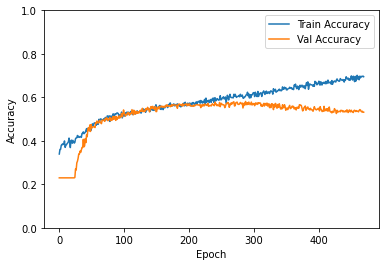

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)